# Transfer Learning with TensorFlow Part 1: Feature Extraction

In [1]:
# Are we using a GPU
! nvidia-smi

Sun Jun 19 11:53:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-06-19 11:59:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   280MB/s    in 0.6s    

2022-06-19 11:59:32 (280 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# how many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}" .')

There are 2 directories and 0 images in "10_food_classes_10_percent" .
There are 10 directories and 0 images in "10_food_classes_10_percent/train" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/fried_rice" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/ramen" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/chicken_curry" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/grilled_salmon" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/chicken_wings" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/sushi" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/pizza" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/ice_cream" .
There are 0 directories and 75 images in "10_food_classes_10_percent/train/hamburger" .
There are 0 directories and 75 images in "10_food_classes

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [7]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images: ')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')


print('Testing Images: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical')

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [9]:
import tensorflow as tf

In [20]:
# Create TensorBoard callback (functionized beause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [10]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [13]:
# import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [15]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [16]:
# Create Resnet model
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)


In [18]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [23]:
# fit the  model
resnet_history = resnet_model.fit(train_data_10_percent, 
                 epochs=5, 
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                  validation_steps=len(test_data),
                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220619-133313
Epoch 1/5
24/24 [==============================] - 16s 679ms/step - loss: 0.2763 - accuracy: 0.9480 - val_loss: 0.6468 - val_accuracy: 0.7848
Epoch 2/5
24/24 [==============================] - 16s 665ms/step - loss: 0.2337 - accuracy: 0.9627 - val_loss: 0.6423 - val_accuracy: 0.7844
Epoch 3/5
24/24 [==============================] - 16s 668ms/step - loss: 0.1973 - accuracy: 0.9773 - val_loss: 0.6277 - val_accuracy: 0.7904
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.1733 - accuracy: 0.9827 - val_loss: 0.6227 - val_accuracy: 0.7896
Epoch 5/5
24/24 [==============================] - 19s 801ms/step - loss: 0.1469 - accuracy: 0.9907 - val_loss: 0.6361 - val_accuracy: 0.7840


In [24]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



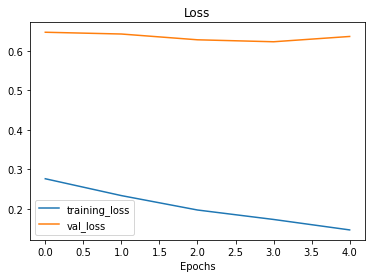

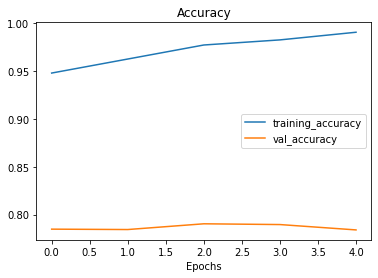

In [25]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [28]:
# Create EfficinetNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%2DB0%20is%20the%20baseline,than%20the%20best%20existing%20CNN.
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220619-134433
Epoch 1/5
24/24 [==============================] - 25s 705ms/step - loss: 1.8676 - accuracy: 0.4293 - val_loss: 1.2945 - val_accuracy: 0.7328
Epoch 2/5
24/24 [==============================] - 15s 635ms/step - loss: 1.0631 - accuracy: 0.7787 - val_loss: 0.8615 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 15s 635ms/step - loss: 0.7554 - accuracy: 0.8333 - val_loss: 0.6897 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 15s 635ms/step - loss: 0.6090 - accuracy: 0.8573 - val_loss: 0.6046 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 15s 640ms/step - loss: 0.5146 - accuracy: 0.8853 - val_loss: 0.5526 - val_accuracy: 0.8616


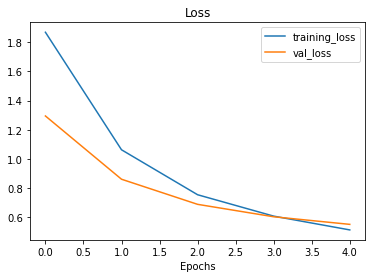

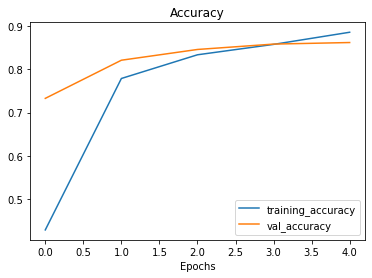

In [29]:
plot_loss_curves(efficientnet_history)

In [30]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [32]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [33]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## Comparing our models results using TensorBoard (in google-colab)

In [ ]:
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
#   --one_shot

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/dQBrpdwIRgS2qI0Andv8Yg/

In [ ]:
# Check out what TensorBoard experiments you have
# !tensorboard dev list

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id dQBrpdwIRgS2qI0Andv8Yg

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
# !tensorboard dev list